# Imports



In [ ]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix,f1_score, roc_auc_score, average_precision_score, precision_score,recall_score 


## Global variables

In [ ]:
# the should be updated based on the dataset 
learning_rate = None
no_itr = None
class_weight = None

# Necessaries Custom Implementation

### logistic Regression Class


In [ ]:
import numpy as np

class CustomLogisticRegression:
    
    # constructor
    def __init__(self, learning_rate=0.01, num_iterations=1500, lambda_=0.001, class_weight=None) :
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        self.weights = None
        self.bias = None
        self.lambda_ = lambda_
        self.class_weight = class_weight

     # sigmoid function with np.clip to prevent overflow
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-np.clip(x, -250, 250)))
        
    def initialize_parameters(self, num_features):
        self.weights = np.zeros(num_features)
        self.bias = 0

    def update_parameters(self, d_weights, d_bias):
        self.weights -= self.learning_rate * d_weights
        self.bias -= self.learning_rate * d_bias 


    # Loss Calculation
    def compute_loss(self, y, prediction):
        # binary cross entropy
        # 1e-9 ---> to avoid taking the logarithm of zero or division by zero
        y_zero_loss = y * np.log(prediction + 1e-9)
        y_one_loss = (1-y) * np.log(1 - prediction + 1e-9)

        if self.class_weight:
            weight_0 = self.class_weight[0]
            weight_1 = self.class_weight[1]
            weighted_loss = -np.mean(weight_1* y_zero_loss + weight_0 * y_one_loss)
        else:
            weighted_loss = -np.mean(y_zero_loss + y_one_loss)
        
        # compute the L2-reularization(Ridge regulation)
        # division by len(y) inorder to normalize 
        l2_regularization = (self.lambda_ / (2*len(y)))*np.sum(np.square(self.weights))
        return  l2_regularization + weighted_loss  
    
     
    def compute_gradients(self, x, y, prediction):
        # derivative of binary cross entropy
        error =  prediction - y
        d_bias = np.mean(error)

        if self.class_weight:
            weight_0 = self.class_weight[0]
            weight_1 = self.class_weight[1]
            weights = np.where(y == 1, weight_1, weight_0)
            error = error * weights

        # compute the L2-regularization
        # since gradient is the derivative of the loss function, so L2 regularization becomes: 
        # lambda/m * w
        d_weights = np.dot(x.T, error) / len(y)
        d_weights = d_weights + ((self.lambda_/len(y)) * self.weights)
        
        return d_weights, d_bias
    
    # main loop where the model computes loss, updates its weights and bias using gradient
    # descent
    def custom_fit(self, x, y, num_iterations=None):

        num_features = x.shape[1]                   # get the number of columns in features
        self.initialize_parameters(num_features)    # initialize weights and bias
        
        if num_iterations:
            self.num_iterations =  num_iterations

        # training loop
        for i in range (self.num_iterations):
            
            x_dot_weights = np.dot(x, self.weights) + self.bias    # X.w
            prediction = self.sigmoid(x_dot_weights)

            # compute loss and gradient
            loss = self.compute_loss(y, prediction)
            d_weights, d_bias = self.compute_gradients(x, y, prediction)

            self.update_parameters(d_weights, d_bias)

    # prediction for test data
    def custom_predict(self, x, threshold=0.5):
        x_dot_weights = np.dot(x, self.weights) + self.bias
        predictions = self.sigmoid(x_dot_weights)

        return np.array([1 if p >threshold else 0 for p in predictions])


## Helper Functions


### For Metric calculation

In [ ]:

## Individual performance metrics
def custom_accuracy(y_true, y_pred):
    cor_pred = np.sum(y_true == y_pred)
    tot_samp = len(y_pred)

    return cor_pred/tot_samp
    

def custom_precision(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    tp = np.sum((y_true==1) & (y_pred==1))
    fp = np.sum((y_true==0) & (y_pred==1))

    return tp/(tp+fp) if (tp+fp)>0 else 0

def custom_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    return tp/(tp+fn) if (tp+fn)>0 else 0

def custom_specificity(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    tn = np.sum((y_true==0) & (y_pred==0))
    fp = np.sum((y_true==0) & (y_pred==1))

    return tn/(tn+fp) if (tn+fp)>0 else 0


def f1_score_(y_true, y_pred):
    return f1_score(y_true, y_pred)

def auroc(y_true, y_pred):
    return roc_auc_score(y_true, y_pred)

def aupr(y_true, y_pred):
    return average_precision_score(y_true, y_pred)


### Ensamble Learning Helper Functions

In [ ]:
# Resampling
def custom_resample(x, y, proportion=1.0, seed = 42):
    """
    Custom function to perform bootstrapping
    """
    np.random.seed(seed)  # Ensure reproducibility
    # sample with replacement

    indices = np.random.choice(np.arange(len(x)), size=int(proportion*len(x)), replace=True)

    # iloc - index the dataframe and reset the index
    x_sampled = x.iloc[indices].reset_index(drop=True)
    y_sampled = y[indices]

    return x_sampled, y_sampled

# create and return bagging models
def create_bagging_models(x_train, y_train, num_models=9, learning_rate=.01, no_itr=1500, class_weight=None):
    """
        x_train: Pandas Dataframe
        y_train: Pandas DataFrame 
    """
    models = []
    for i in range (num_models):
        x_resampled, y_resampled = custom_resample(x_train, y_train, seed=44+i)
        
        if class_weight:
            model = CustomLogisticRegression(learning_rate = learning_rate, num_iterations= no_itr, class_weight=class_weight)
        else:
            model = CustomLogisticRegression(num_iterations=no_itr, learning_rate=learning_rate)
            
        model.custom_fit(x_resampled, y_resampled)
         
        models.append(model)

    return models

# return the predictions from the bagging models
def get_predictions_from_bagged_models(models, x):
    """
        get predictions from a list of models against the input data X
        
        X: pandas dataframe
    """
    return np.array([model.custom_predict(x) for model in models]).T

# augment the predictions to the validation set
def augment_predictions_to_validation_set(models, x_validation):
    """
        Augment the results got against the validation set from the models 

        Returns: 
            Augmented Pandas DataFrame 
    """
    model_predictions = get_predictions_from_bagged_models(models, x_validation)

    # create columns
    cols = [f'model_{i+1}' for i in range(model_predictions.shape[1])]

    x_validation_df = pd.DataFrame(x_validation)
    model_predictions_df = pd.DataFrame(model_predictions, columns=cols)


    augmented_validation_df = pd.concat([x_validation_df, model_predictions_df], axis=1)

    return augmented_validation_df

# train the meta classifier
def train_meta_classifier(augmented_validation_df, y_validation, learning_rate = .01, no_itr=1500, class_weight=None):
    """
        augmented_validation_df : 
            augmented validation dataframe as features
        y_validation: 
            y values of validation set as target
        learning rate: 
            for setting up the model
        no_itr:
            for the model
        class_weight:
            for imbalanced dataset
        return the meta classifier that is trained using the augmented validation set 
    """
    if class_weight:
        meta_model = CustomLogisticRegression(learning_rate=learning_rate, num_iterations = no_itr, class_weight=class_weight)
    else:
        meta_model = CustomLogisticRegression(learning_rate=learning_rate, num_iterations = no_itr)

    meta_model.custom_fit(augmented_validation_df, y_validation)
    return meta_model

    

### Majority Voting Class

In [ ]:

class MajorityVoting :
    def __init__(self, models):
        self.models = models
    
    def custom_prediction(self, x):
        """
        Parameters: 
            x is the data against which we shall predict
        """

        # make predictions from the models
        predictions =  np.array([model.custom_predict(x) for model in self.models])

        # get the majority votes
        majority_votes, count = stats.mode(predictions, axis=0)

        # convert to 1D array
        return majority_votes.ravel()


### Metrics Class

In [ ]:

class Metrics:
    def __init__(self) :
        self.metrics = {
            'accuracy':[],
            'sensitivity':[],
            'specificity':[],
            'precision':[],
            'f1-score':[],
            'auroc':[],
            'aupr':[]
        }

    def update_the_metrics(self, y_true, y_pred):
        self.metrics['accuracy'].append(custom_accuracy(y_true, y_pred))
        self.metrics['sensitivity'].append(custom_sensitivity(y_true, y_pred))
        self.metrics['precision'].append(custom_precision(y_true, y_pred))
        self.metrics['specificity'].append(custom_specificity(y_true, y_pred))
        self.metrics['f1-score'].append(f1_score_(y_true, y_pred))
        self.metrics['auroc'].append(auroc(y_true, y_pred))
        self.metrics['aupr'].append(aupr(y_true, y_pred))

    def calculate_mean_stddev(self):
        for metric_name, values in self.metrics.items():
            if values:
                mean = np.mean(values)
                stddev = np.std(values)
                self.metrics[metric_name].clear()
                self.metrics[metric_name].append(mean+stddev)

    def get_metrics_summary(self):
        summary = {}
        for metric_name, values in self.metrics.items():
            if values:
                summary[metric_name] = values[0]
        return summary

    def print_(self):
        for metric_name, values in self.metrics.items():
            print(f'{metric_name} : {values}')


### Model based metric calculation Helper functions

In [ ]:
# metrics for all the 9 LR models
def lr_metric_calculator(models, X_test, y_test,threshold=0.5):
    
    lr_metrics = Metrics()

    # predict the models against the 'X_test' and update the performance metrics
    for model in models:
        y_pred = model.custom_predict(X_test, threshold=threshold)
        # y_pred = model.predict(X_test)
        lr_metrics.update_the_metrics(y_test, y_pred)

    return lr_metrics

# for the stacking metrics
def stacking_metric_calculator(model, X_test, y_test, threshold=0.5):
    
    st_metrics = Metrics()

    # predict the model against the 'X_test' and update the performance metrics
    
    y_pred = model.custom_predict(X_test, threshold=threshold)
    st_metrics.update_the_metrics(y_test, y_pred)

    return st_metrics

# for majority voting
def voting_metric_calculator(model, X_test, y_test):
    
    vt_metrics = Metrics()

    # predict the model against the 'X_test' and update the performance metrics
    
    y_pred = model.custom_prediction(X_test)
    vt_metrics.update_the_metrics(y_test, y_pred)

    return vt_metrics

# plot the violin plot
def plot_violin(lr_metrics_data):
    # Plotting the violin plots for each metric
    plt.figure(figsize=(15, 10))

    for i, (metric_name, values) in enumerate(lr_metrics_data.metrics.items(), 1):
        plt.subplot(3, 3, i)
        sns.violinplot(data=[values], inner="point")
        plt.title(f'Violin plot of {metric_name}')
        plt.ylabel('Score')

    plt.tight_layout()
    plt.show()

## Helper functions for PreProcessing

In [ ]:
# drop the duplicated rows
def drop_duplicates(dataframe):
    dataframe.drop_duplicates(inplace=True)
    return dataframe

# separate the data frame into features and target
def create_feature_target(dataframe, column=''):
    features = dataframe.drop(column, axis=1)
    target = dataframe[column]
    return features, target

# label encode the target
def label_encoding_target_helper(target, cols=[]):
    le = LabelEncoder()
    target = le.fit_transform(target.values.ravel())
    target = pd.DataFrame(target, columns=cols)
    return target

# label encode the feature
def label_encoding_features_helper(features):
    # Label Encode binary columns
    binary_cols = [c for c in features.columns if features[c].dtype not in ['int64', 'float64'] and features[c].nunique() == 2]
    binary_cols
    le = LabelEncoder()

    for c in binary_cols:
        features[c] = le.fit_transform(features[c])

    return features

# one hot encoding
def one_hot_helper(features):
    # OneHot encoding
    object_cols = features.select_dtypes(include=['object']).columns


    # chage the datatype to category
    for c in object_cols:
        features[c] = features[c].astype('category')

    features = pd.get_dummies(features)
    features = features.astype('int')
    return features

# scaling helper
def scaling_helper(features, scaler='minmax'):
    # we separate the binary cols
    binary_cols = [c for c in features.columns if features[c].nunique() == 2]

    binary_features = features[binary_cols]
    continous_features = features.drop(columns=binary_cols)

    if scaler == 'standard':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    
    scaled_features = scaler.fit_transform(continous_features)
    continous_features = pd.DataFrame(scaled_features, columns=continous_features.columns)

    # reset the index
    binary_features.reset_index(drop=True, inplace=True)

    #concat the two matrices
    features = pd.concat([binary_features,continous_features], axis=1)
    return features

# correlation helper
def correlation_helper(features, target, target_col_name):
    target_series = target[target_col_name]
    correlations = features.corrwith(target_series)
    return pd.DataFrame({'Feature': correlations.index, 'Correlation': correlations.values})

def information_gain_helper(features, target):
    mi = mutual_info_classif(features,target)
    return pd.DataFrame({'Feature': features.columns, 'Information Gain': mi})

def get_top_features(correlations, info_gain, top=40):
    # Combine DataFrames
    combined_df = info_gain.merge(correlations, on='Feature', how='inner')
    
    # Calculate a combined score based on absolute values
    combined_df['Absolute Info Gain'] = combined_df['Information Gain'].abs()
    combined_df['Absolute Correlation'] = combined_df['Correlation'].abs()
    combined_df['Combined Score'] = combined_df['Absolute Info Gain'] + combined_df['Absolute Correlation']
    
    # Sort by combined score
    combined_df = combined_df.sort_values(by='Combined Score', ascending=False)
    
    #return the top features
    return combined_df.head(top)['Feature'] 


# Data splitter
def split_data(features, target, test_size=0.2, random_state=42):
    
    # Check if the target is a pandas DataFrame/Series
    if isinstance(target, pd.DataFrame) or isinstance(target, pd.Series):
        target = target.values.ravel()  # Convert to 1D numpy array
    
    # If it's already a numpy array and has more than 1 dimension, flatten it
    elif isinstance(target, np.ndarray) and target.ndim > 1:
        target = target.ravel()
    
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_size, random_state=random_state)
    

    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = pd.Series(y_train).reset_index(drop=True).to_numpy().ravel()
    y_test = pd.Series(y_test).reset_index(drop=True).to_numpy().ravel()

    return X_train, X_test, y_train, y_test


# First Dataset PreProcessing (Churn)

In [225]:

# read the csv file
dataframe = pd.read_csv("../Program_Data/churn.csv")

# remove the customer Id column from the dataset
dataframe = dataframe.drop('customerID', axis=1)

'''
because of space in some cell of the TotalCharges column,
the datatype of the column has changed to Object

Convert the space filled cells with NaN 
then convert the whole column to numeric
find the mean of the column
fill the NaN with the mean

'''

dataframe['TotalCharges'] = dataframe['TotalCharges'].replace(' ', np.nan)

dataframe['TotalCharges'] = pd.to_numeric(dataframe['TotalCharges'], errors='coerce')

mean = dataframe['TotalCharges'].mean()

dataframe['TotalCharges'] = dataframe['TotalCharges'].fillna(mean)

dataframe['TotalCharges'].dtype

# remove the duplicated rows
dataframe.drop_duplicates(inplace=True)

# create features and target
features = dataframe.drop('Churn', axis=1)
target = dataframe['Churn']

# Label encode target
target = label_encoding_target_helper(target, ['Churn'])

# Label Encode binary columns
features = label_encoding_features_helper(features)

# OneHot encoding
features = one_hot_helper(features)

# Scaling
features = scaling_helper(features)


print("\n**********After scaling: ")
print(f'features.shape = {features.shape}   target.shape = {target.shape}')


# feature selection
correlations = correlation_helper(features, target, 'Churn')

info_gain = information_gain_helper(features, target.values.ravel())


# select top 30 features combining both the correlations and info_gain
features_top = get_top_features(correlations, info_gain, top=30)


# filter the feature 
filtered_features = features[features_top]

# get the test and train set
X_train, X_test, y_train, y_test = split_data(filtered_features, target, test_size=0.2, random_state=42)

# get the train and validation set
X_train, X_validation, y_train, y_validation = split_data(X_train, y_train, test_size=0.2, random_state=42)

print("\n**********Before fitting")
print(f'X_train.shape = {X_train.shape}   y_train.shape = {y_train.shape}')
print(f'X_validation.shape = {X_validation.shape}     y_validation.shape = {y_validation.shape}')
print(f'X_test.shape = {X_test.shape}     y_test.shape = {y_test.shape}')


# update the global variables
learning_rate = .01
no_itr = 2500




**********After scaling: 
features.shape = (7021, 40)   target.shape = (7021, 1)

**********Before fitting
X_train.shape = (4492, 30)   y_train.shape = (4492,)
X_validation.shape = (1124, 30)     y_validation.shape = (1124,)
X_test.shape = (1405, 30)     y_test.shape = (1405,)


# Second DataSet PreProcessing (adult)

In [226]:

# columns = ['age','workclass', 'fnlwgt', 'education','education-num','marital-status', 'occupation','relationship','race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# dataframe = pd.read_csv('../Program_Data/adult/adult.data', header=None, names=columns, na_values='?', skipinitialspace=True)
# test_df = pd.read_csv('../Program_Data/adult/adult.test', header=None, names=columns, na_values='?', skipinitialspace=True)

# # drop the first row since it consists of unnecessary data
# test_df = test_df.drop(index=0)
 
# # Reset the index
# test_df.reset_index(drop=True, inplace=True)

# print("\n**********After reading the files")
# print(f'dataframe.shape = {dataframe.shape}')
# print(f'test.shape = {test_df.shape}')


# # handle duplicates
# dataframe = drop_duplicates(dataframe)
# test_df = drop_duplicates(test_df)

# print("\n**********After handling duplicates")
# print(f'dataframe.shape = {dataframe.shape}')
# print(f'test.shape = {test_df.shape}')


# #  handle missing values -- drop the rows that have null entries
# dataframe.dropna(subset=['workclass', 'occupation', 'native-country','income'], inplace=True)

# # test_dataframe
# test_df.dropna(subset=['workclass', 'occupation', 'native-country','income'], inplace=True)

# print("\n**********After dropping the null rows")
# print(f'dataframe.shape = {dataframe.shape}')
# print(f'test.shape = {test_df.shape}')

# # # instead of removing, use the mode of each column to fill the nan
# # # For each column, calculate the mode and fill missing values
# # for column in ['workclass', 'occupation', 'native-country']:
# #     mode_value = dataframe[column].mode()[0]  # Get the most frequent value (mode)
# #     dataframe[column] = dataframe[column].fillna(mode_value)


# # dataframe.isnull().sum()

# # separate into features and target
# features, target = create_feature_target(dataframe, column='income')
# test_features, test_target = create_feature_target(test_df, column='income')

# print("\n**********After separation into features and target")
# print(f'features.shape = {features.shape}   target.shape = {target.shape}')
# print(f'test_features.shape = {test_features.shape}     test_target.shape = {test_target.shape}')


# #encoding
# # label encode target
# target = label_encoding_target_helper(target, cols=['income'])
# # print(target)

# # label encode test_target
# test_target = label_encoding_target_helper(test_target, cols=['income'])
# # print(test_target)

# # labelEncode features
# features = label_encoding_features_helper(features)
# # print(f'features.shape = {features.shape} ')

# # labelEncode test features
# test_features = label_encoding_features_helper(test_features)
# # print(f'test_features.shape = {test_features.shape} ')

# print("\n**********After label encoding")
# print(f'features.shape = {features.shape}   target.shape = {target.shape}')
# print(f'test_features.shape = {test_features.shape}     test_target.shape = {test_target.shape}')


# # OneHot encoding
# features = one_hot_helper(features)
# # print(features)

# # OneHot encoding of the test_features
# test_features = one_hot_helper(test_features)
# # print(test_features)

# # Align the test set with the training set columns, filling missing columns with 0
# test_features = test_features.reindex(columns=features.columns, fill_value=0)


# print("\n**********After one hot encoding and alignment")
# print(f'features.shape = {features.shape}   target.shape = {target.shape}')
# print(f'test_features.shape = {test_features.shape}     test_target.shape = {test_target.shape}')

# # Check for column consistency and order
# assert all(features.columns == test_features.columns), "Columns mismatch between training and test sets!"

# features = features.reset_index(drop=True)
# test_features = test_features.reset_index(drop=True)


# # Scaling of the featues
# features = scaling_helper(features, scaler='minmax')
# # print(features)

# # Scaling of the test features
# test_features = scaling_helper(test_features, scaler='minmax')
# # print(test_features)


# # feature selection
# correlations = correlation_helper(features, target, 'income')

# info_gain = information_gain_helper(features, target.values.ravel())


# # select top 40 features combining both the correlations and info_gain
# features_top = get_top_features(correlations, info_gain, top=40)


# # filter the feature and the test_feature set
# filtered_features = features[features_top]
# filtererd_test = test_features[features_top]



# # get the validation and train set
# X_train, X_validation, y_train, y_validation = split_data(filtered_features, target, test_size=0.2, random_state=42)


# X_test = filtererd_test
# y_test = test_target.values.ravel()

# print("\n**********Before fitting")
# print(f'X_train.shape = {X_train.shape}   y_train.shape = {y_train.shape}')
# print(f'X_test.shape = {X_test.shape}     y_test.shape = {y_test.shape}')

# no_itr = 1500
# learning_rate = 0.01



# Third Dataset Preprocessing (CreditCard)

In [227]:
# dataframe = pd.read_csv('../Program_Data/creditcard.csv')

# #  no null value in the cells


# # drop the duplicated rows
# # since no positive values in the duplicated rows, they can also be deleted
# dataframe = drop_duplicates(dataframe)


# # take 20,000 randomly from the negative class and take all the positive class data
# negative_class = dataframe[dataframe['Class']==0]
# positive_class = dataframe[dataframe['Class']==1]

# negative_class = negative_class.sample(20000, random_state=42)

# # concat the two class and reshuffle them to mix the classes
# dataframe = pd.concat([negative_class, positive_class])
# dataframe = dataframe.sample(frac=1, random_state=42).reset_index(drop=True)


# # separate into features and target
# features, target = create_feature_target(dataframe, column='Class')


# # scale the features
# features = scaling_helper(features, scaler='minmax')

# # feature selection
# # since there are only 30 columns, we avoid the feature selection part

# # split the dataset to train and test
# X_train, X_test, y_train, y_test = split_data(features, target)

# # create the validation set
# X_train, X_validation, y_train, y_validation = split_data(X_train, y_train)


# # assign weights for the class
# weight_0 = 0.098
# weight_1 = 0.902

# class_weight = {0:weight_0, 1:weight_1}
# learning_rate = 0.0001
# no_itr = 5000


# print("\n**********Before fitting")
# print(f'X_train.shape = {X_train.shape}   y_train.shape = {y_train.shape}')
# print(f'X_validation.shape = {X_validation.shape}     y_validation.shape = {y_validation.shape}')
# print(f'X_test.shape = {X_test.shape}     y_test.shape = {y_test.shape}')
# print(f'0s in train:{np.sum(y_train == 0)}  1s in train: {np.sum(y_train==1)}' )
# print(f'0s in test:{np.sum(y_test == 0)}  1s in test: {np.sum(y_test==1)}' )
# print(f'class_weight = {class_weight}')





# Validiation

## Validation with Library function

In [228]:
if class_weight:
    lr = LogisticRegression(class_weight='balanced')
else:
    lr = LogisticRegression()

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

lib_accuracy = accuracy_score(y_test, y_pred)
lib_precision = precision_score(y_test, y_pred)
lib_recall = recall_score(y_test, y_pred)
lib_f1 = f1_score(y_test, y_pred)
lib_auroc = roc_auc_score(y_test, y_pred)  # Use predicted probabilities for AUROC
lib_aupr = average_precision_score(y_test, y_pred)  # Precision-Recall AUC
lib_conf_matrix = confusion_matrix(y_test, y_pred)
lib_tp, lib_fp, lib_fn, lib_tn = lib_conf_matrix.ravel()
lib_sensitivity = lib_tp/(lib_tp+lib_fn) if (lib_tp+lib_fn)>0 else 0
lib_specificity = lib_tn/(lib_tn+lib_fp) if (lib_tn+lib_fp)>0 else 0


print(f'The accuracy of skLearn.LogisticRegression : {lib_accuracy:.2f}')
print(f'The precision of skLearn.LogisticRegression : {lib_precision:.2f}')
print(f'The recall of skLearn.LogisticRegression : {lib_recall:.2f}')
print(f'The f1 of skLearn.LogisticRegression : {lib_f1:.2f}')
print(f'The auroc of skLearn.LogisticRegression : {lib_auroc:.2f}')
print(f'The aupr of skLearn.LogisticRegression : {lib_aupr:.2f}')
print(f'The sensitivity of skLearn.LogisticRegression : {lib_sensitivity:.2f}')
print(f'The specificity of skLearn.LogisticRegression : {lib_specificity:.2f}')



The accuracy of skLearn.LogisticRegression : 0.74
The precision of skLearn.LogisticRegression : 0.49
The recall of skLearn.LogisticRegression : 0.80
The f1 of skLearn.LogisticRegression : 0.61
The auroc of skLearn.LogisticRegression : 0.76
The aupr of skLearn.LogisticRegression : 0.44
The sensitivity of skLearn.LogisticRegression : 0.92
The specificity of skLearn.LogisticRegression : 0.49


## Validating Custom Regression

### Create the nine models 

In [229]:
 
# time needed: 
#   - second dataset (5 m 8.6 s)
#   - third dataset (1 m.4 s)
models = create_bagging_models(X_train, y_train, learning_rate=learning_rate, no_itr=no_itr, class_weight=class_weight)
 

### Metrics calculation for the LR Models against the Test set and Violin plot


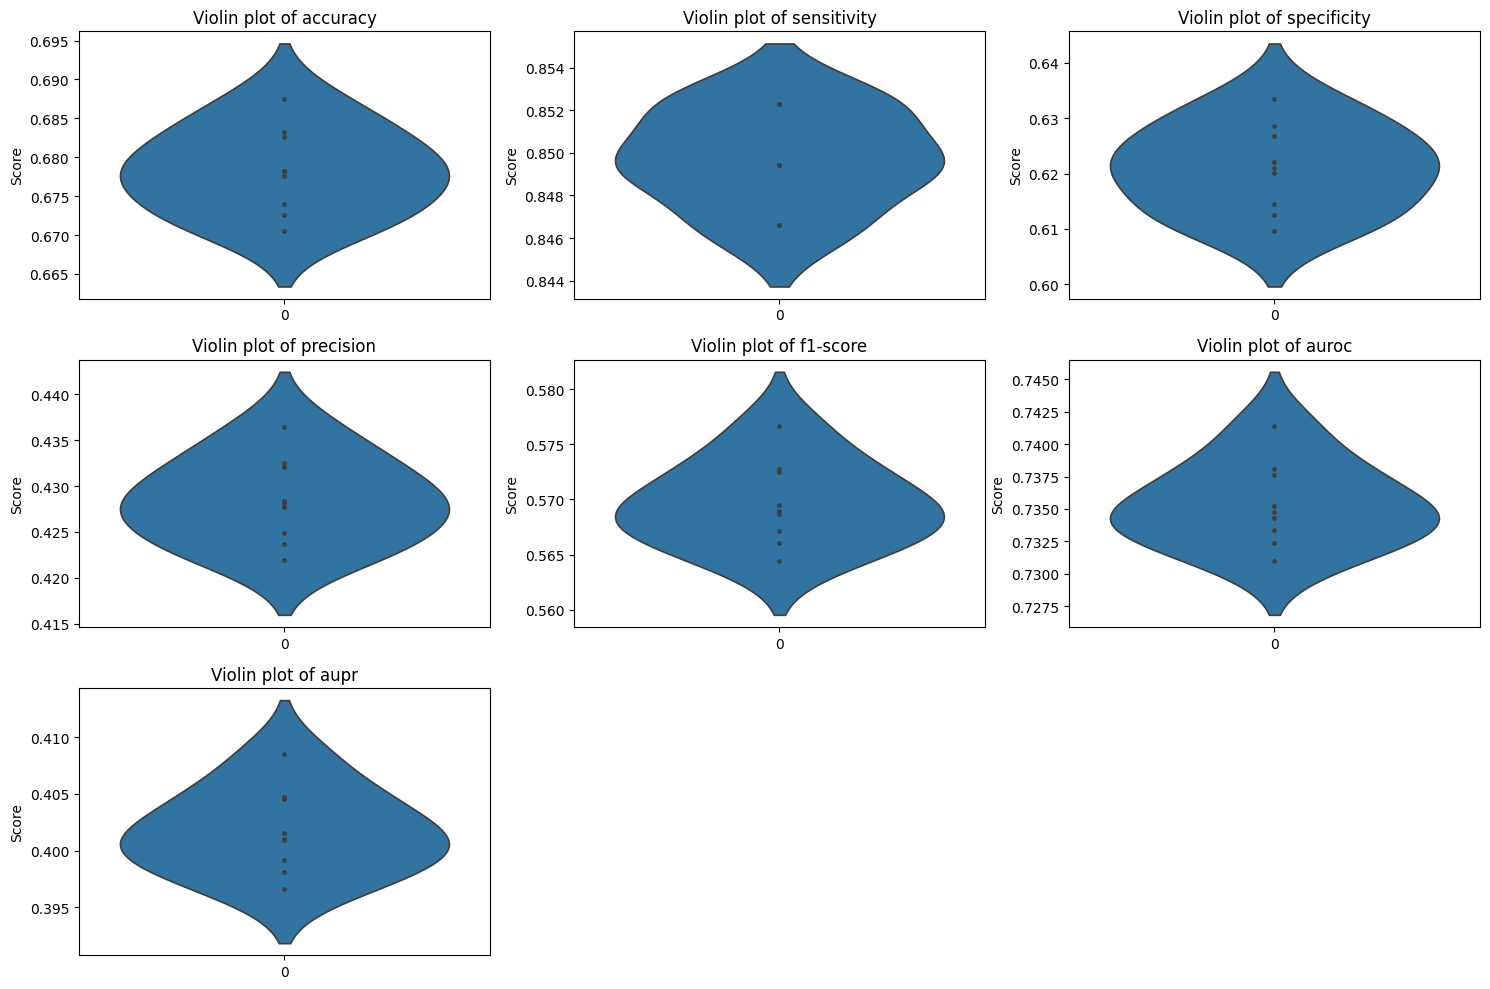

In [230]:
# create the metrics for LR

if class_weight:
    lr_metrics = lr_metric_calculator(models, X_test, y_test, threshold=0.4095)
else:
    print(1)
    lr_metrics = lr_metric_calculator(models, X_test, y_test, threshold=0.5)

plot_violin(lr_metrics)

### The mean Metrics

In [231]:
# find the mean+stddev for each of the metric in lr_metrices
lr_metrics.calculate_mean_stddev()

# view the result
lr_metrics.print_()

accuracy : [np.float64(0.683467953553801)]
sensitivity : [np.float64(0.8518413035292647)]
specificity : [np.float64(0.6283664203439957)]
precision : [np.float64(0.4328131794377845)]
f1-score : [np.float64(0.5732227609340642)]
auroc : [np.float64(0.7383983164569369)]
aupr : [np.float64(0.40519625164970835)]


### Stacking

In [232]:
# The models are already trained
# augment the result that achieved against the validation set with the validation set

augmented_validation_df = augment_predictions_to_validation_set(models, X_validation)

# train the meta-Classifier-Model
 
meta_classifier_model = train_meta_classifier(augmented_validation_df, y_validation, no_itr=no_itr, learning_rate=learning_rate, class_weight=class_weight)
 


# for prediction the test data need to have the same columns as the trained data
# So we also need to augment to the test_set, The results
augmented_test_df = augment_predictions_to_validation_set(models, X_test)




### Metric calculation for Stacking

In [233]:
#  metric calculation for Stack Models

if class_weight:
    stack_metrics = stacking_metric_calculator(meta_classifier_model, augmented_test_df, y_test, threshold=0.4095)  
else:
    stack_metrics = stacking_metric_calculator(meta_classifier_model, augmented_test_df, y_test, threshold=0.5)

stack_metrics.print_()

accuracy : [np.float64(0.7074733096085409)]
sensitivity : [np.float64(0.8210227272727273)]
specificity : [np.float64(0.6695156695156695)]
precision : [np.float64(0.45368916797488223)]
f1-score : [np.float64(0.5844287158746209)]
auroc : [np.float64(0.7452691983941985)]
aupr : [np.float64(0.41732897567607785)]


### Metric calculation for Majority Voting

In [234]:
# metric calculation for majority voting

voter = MajorityVoting(models)

vt_metrics = voting_metric_calculator(voter, X_test, y_test)

vt_metrics.print_()


accuracy : [np.float64(0.7103202846975089)]
sensitivity : [np.float64(0.8153409090909091)]
specificity : [np.float64(0.6752136752136753)]
precision : [np.float64(0.4562798092209857)]
f1-score : [np.float64(0.5851172273190621)]
auroc : [np.float64(0.7452772921522922)]
aupr : [np.float64(0.4182869396457946)]


# Create Table for comparisn 

In [235]:
comparison_data = {
    'Metric': ['Accuracy', 'Sensitivity', 'Specificity', 'Precision', 'F1-Score', 'AUROC', 'AUPR'],
    'Logistic Regression': lr_metrics.get_metrics_summary().values(),
    'Voting Ensemble': vt_metrics.get_metrics_summary().values(),
    'Stacking Ensemble': stack_metrics.get_metrics_summary().values()
}

comparison_df = pd.DataFrame(comparison_data).set_index('Metric').transpose()

comparison_df


Metric,Accuracy,Sensitivity,Specificity,Precision,F1-Score,AUROC,AUPR
Logistic Regression,0.683468,0.851841,0.628366,0.432813,0.573223,0.738398,0.405196
Voting Ensemble,0.710320,0.815341,0.675214,0.456280,0.585117,0.745277,0.418287
Stacking Ensemble,0.707473,0.821023,0.669516,0.453689,0.584429,0.745269,0.417329
